In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchattacks
import seaborn as sns

from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
def load_data(csv_path):
	df = pd.read_csv(csv_path)
	df.dropna(axis=1, how='any', inplace=True)
	
	numeric_columns = df.select_dtypes(include=[np.number])
	numeric_columns = numeric_columns.loc[:, ~np.isinf(numeric_columns.values).any(axis=0)]
	numeric_columns = numeric_columns.loc[:, numeric_columns.nunique() > 1]
	non_numeric_cols = df.select_dtypes(exclude=[np.number])
	
	df = pd.concat([non_numeric_cols, numeric_columns], axis=1)
	df.drop_duplicates(inplace=True)
	df.rename(columns={' Label': 'Label'}, inplace=True)
	
	label_col = 'Label'
	feature_cols = [col for col in df.columns if col != label_col]
	df[label_col] = df[label_col].map({'BENIGN': 0}).fillna(1)
	
	scaler = StandardScaler()
	df[feature_cols] = scaler.fit_transform(df[feature_cols])
	return df, feature_cols, label_col

In [35]:
class CICDataset(Dataset):
	def __init__(self, dataframe, features, label_col):
		self.X = torch.tensor(dataframe[features].values, dtype=torch.float32)
		self.y = torch.tensor(dataframe[label_col].values, dtype=torch.float32).unsqueeze(1)
	def __len__(self):
		return len(self.X)
	def __getitem__(self, idx):
		return self.X[idx], self.y[idx]

In [36]:
class BinaryClassifier(nn.Module):
	def __init__(self, input_dim):
		super(BinaryClassifier, self).__init__()
		
		self.net = nn.Sequential(
			nn.Linear(input_dim, 128),
			nn.ReLU(),
			nn.BatchNorm1d(128),
			nn.Dropout(0.3),

			nn.Linear(128, 64),
			nn.ReLU(),
			nn.BatchNorm1d(64),
			nn.Dropout(0.3),

			nn.Linear(64, 32),
			nn.ReLU(),
			nn.BatchNorm1d(32),
			nn.Dropout(0.2),
			
			nn.Linear(32, 1),
			nn.Sigmoid()
		)
		
	def forward(self, x):
		return self.net(x)

In [37]:
def evaluate_model(model, dataloader):
	model.eval()
	y_true, y_pred = [], []
	with torch.no_grad():
		for x, y in dataloader:
			x = x.to(device)
			output = model(x)
			pred = (output > 0.5).int().cpu().numpy()
			y_pred.extend(pred)
			y_true.extend(y.numpy())
	return y_true, y_pred

In [38]:
def plot_attack_metrics(metrics, attack_name):
	labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
	pre = [metrics["Pre-Attack"][label] for label in labels]
	post = [metrics[f"{attack_name} - Post Attack"][label] for label in labels]
	post_def = [metrics[f"{attack_name} - Post Defence"][label] for label in labels]

	groups = ['Pre-Attack', 'Post-Attack', 'Post-Defence']
	data = [pre, post, post_def]

	x = np.arange(len(groups))
	width = 0.2

	_, ax = plt.subplots(figsize=(10, 6))

	for i, label in enumerate(labels):
		ax.bar(x + (i - 1.5)*width, [d[i] for d in data], width, label=label)

	ax.set_ylabel('Score')
	ax.set_title(f'Metric Comparison for {attack_name}')
	ax.set_xticks(x)
	ax.set_xticklabels(groups)
	ax.set_ylim(0, 1)
	ax.legend()
	plt.tight_layout()
	plt.show()

In [39]:
def adversarial_training(csv_path, subset_ratio=1.0):
	df, features, label = load_data(csv_path)
	dataset = CICDataset(df, features, label)

	np.random.seed(42)

	if subset_ratio < 1.0:
		subset_size = int(len(dataset) * subset_ratio)
		indices = np.random.permutation(len(dataset))[:subset_size]
		dataset = Subset(dataset, indices)
	
	train_size = int(0.8 * len(dataset))
	train_set, test_set = random_split(dataset, [train_size, len(dataset) - train_size])
	val_size = int(0.2 * len(train_set))
	
	train_size_final = len(train_set) - val_size
	train_set, val_set = random_split(train_set, [train_size_final, val_size])
	
	train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
	val_loader = DataLoader(val_set, batch_size=64)
	test_loader = DataLoader(test_set, batch_size=64)
	
	model = BinaryClassifier(len(features)).to(device)
	model.load_state_dict(torch.load("best_model.pth", map_location=device))
	
	y_true, y_pred = evaluate_model(model, test_loader)

	num_epochs = 100
	
	metrics = {}
	
	metrics["Pre-Attack"] = {
		"Accuracy": round(accuracy_score(y_true, y_pred), 3),
		"Precision": round(precision_score(y_true, y_pred), 3),
		"Recall": round(recall_score(y_true, y_pred), 3),
		"F1-score": round(f1_score(y_true, y_pred), 3)
	}
	
	print("Pre-Attack:", metrics["Pre-Attack"])
	
	cm = confusion_matrix(y_true, y_pred)
	sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
	plt.title("Confusion Matrix Pre-Attack")
	plt.show()
	
	attacks = {
		"FGSM": torchattacks.FGSM(model, eps=0.1),
		"PGD": torchattacks.PGD(model, eps=0.1, alpha=0.01)
	}
	
	for name, attack in attacks.items():
		adv_preds, adv_true = [], []
		for x, y in test_loader:
			x, y = x.to(device), y.to(device).float().view(-1, 1)
			x_adv = attack(x, y)
			pred = (model(x_adv) > 0.5).int().cpu().numpy()
			adv_preds.extend(pred)
			adv_true.extend(y.cpu().numpy())
		
		metrics[f"{name} - Post Attack"] = {
			"Accuracy": round(accuracy_score(adv_true, adv_preds), 3),
			"Precision": round(precision_score(adv_true, adv_preds), 3),
			"Recall": round(recall_score(adv_true, adv_preds), 3),
			"F1-score": round(f1_score(adv_true, adv_preds), 3)
		}
		
		print(f"Post {name}:", metrics[f"{name} - Post Attack"])
		
		cm = confusion_matrix(adv_true, adv_preds)
		sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
		plt.title(f"Confusion Matrix Post {name} Attack")
		plt.show()
		
		print(f"\nAdversarial training for the attack: {name}.")
		
		adv_model = BinaryClassifier(len(features)).to(device)
		adv_opt = optim.Adam(adv_model.parameters(), lr=0.001)
		
		loss_fn = nn.BCELoss()
		
		best_val_loss = float('inf')
		patience = 5
		patience_counter = 0

		train_losses = []
		val_losses = []
		train_accuracies = []
		val_accuracies = []
		
		for epoch in range(num_epochs):
			
			adv_model.train()
			train_loss = 0.0
			train_correct = 0
			train_total = 0
			
			for x, y in train_loader:
				x, y = x.to(device), y.to(device).float().view(-1, 1)
				x_adv = attack(x, y)
				
				adv_opt.zero_grad()
				out = adv_model(x_adv)
				loss = loss_fn(out, y)
				loss.backward()
				adv_opt.step()
				
				train_loss += loss.item()
				train_pred = (out > 0.5).float()
				train_correct += (train_pred == y).sum().item()
				train_total += y.size(0)
			
			train_loss /= len(train_loader)
			train_acc = train_correct / train_total
			
			adv_model.eval()
			val_loss = 0.0
			val_correct = 0
			val_total = 0
			
			for x, y in val_loader:
				x, y = x.to(device), y.to(device).float().view(-1, 1)
				x_adv = attack(x, y)
				
				with torch.no_grad():
					out = adv_model(x_adv)
					loss = loss_fn(out, y)
					val_loss += loss.item()
					val_pred = (out > 0.5).float()
					val_correct += (val_pred == y).sum().item()
					val_total += y.size(0)
			
			val_loss /= len(val_loader)
			val_acc = val_correct / val_total

			train_losses.append(train_loss)
			val_losses.append(val_loss)
			train_accuracies.append(train_acc)
			val_accuracies.append(val_acc)
			
			print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
			
			if val_loss < best_val_loss:
				best_val_loss = val_loss
				patience_counter = 0
				torch.save(adv_model.state_dict(), f'best_adv_model_{name.lower()}.pth')
			else:
				patience_counter += 1
				
			if patience_counter >= patience:
				print("Early stopping triggered.\n")
				break

		epochs_range = range(1, len(train_losses) + 1)

		plt.figure()
		plt.plot(epochs_range, train_losses, label='Train Loss')
		plt.plot(epochs_range, val_losses, label='Val Loss')
		plt.title(f'{name} - Loss over Epochs')
		plt.xlabel("Epochs")
		plt.ylabel("Loss")
		plt.legend()
		plt.tight_layout()
		plt.show()


		plt.figure()
		plt.plot(epochs_range, train_accuracies, label='Train Acc')
		plt.plot(epochs_range, val_accuracies, label='Val Acc')
		plt.title(f'{name} - Accuracy over Epochs')
		plt.xlabel("Epochs")
		plt.ylabel("Accuracy")
		plt.legend()
		plt.tight_layout()
		plt.show()
		
		adv_model.load_state_dict(torch.load(f'best_adv_model_{name.lower()}.pth', map_location=device))
		
		adv_model.eval()
		post_def_preds, post_def_true = [], []
		
		for x, y in test_loader:
			x, y = x.to(device), y.to(device).float().view(-1, 1)
			x_adv = attack(x, y)
			pred = (adv_model(x_adv) > 0.5).int().cpu().numpy()
			post_def_preds.extend(pred)
			post_def_true.extend(y.cpu().numpy())
		
		metrics[f"{name} - Post Defence"] = {
			"Accuracy": round(accuracy_score(post_def_true, post_def_preds), 3),
			"Precision": round(precision_score(post_def_true, post_def_preds), 3),
			"Recall": round(recall_score(post_def_true, post_def_preds), 3),
			"F1-score": round(f1_score(post_def_true, post_def_preds), 3)
		}
		
		print("Post-Defence:", metrics[f"{name} - Post Defence"])
		
		cm = confusion_matrix(post_def_true, post_def_preds)
		sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
		plt.title(f"Confusion Matrix Post {name} Defence")
		plt.show()
	
	for attack in attacks.keys():
		plot_attack_metrics(metrics, attack)

Pre-Attack: {'Accuracy': 0.988, 'Precision': 0.971, 'Recall': 0.955, 'F1-score': 0.963}


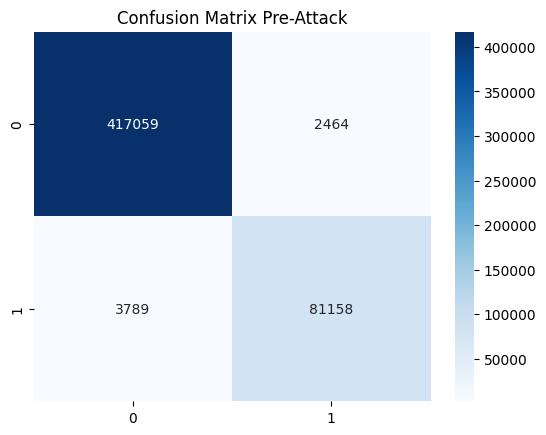

Post FGSM: {'Accuracy': 0.832, 'Precision': 0.059, 'Recall': 0.0, 'F1-score': 0.0}


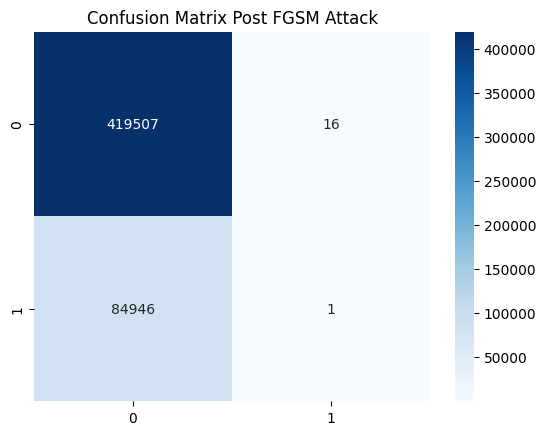


Adversarial training for the attack: FGSM.
Epoch 1/100 - Train Loss: 0.0770, Val Loss: 0.0607 - Train Acc: 0.9640, Val Acc: 0.9698
Epoch 2/100 - Train Loss: 0.0664, Val Loss: 0.0591 - Train Acc: 0.9679, Val Acc: 0.9711
Epoch 3/100 - Train Loss: 0.0641, Val Loss: 0.0636 - Train Acc: 0.9689, Val Acc: 0.9731
Epoch 4/100 - Train Loss: 0.0636, Val Loss: 0.0622 - Train Acc: 0.9696, Val Acc: 0.9713
Epoch 5/100 - Train Loss: 0.0631, Val Loss: 0.0685 - Train Acc: 0.9701, Val Acc: 0.9723
Epoch 6/100 - Train Loss: 0.0624, Val Loss: 0.0588 - Train Acc: 0.9706, Val Acc: 0.9721
Epoch 7/100 - Train Loss: 0.0620, Val Loss: 0.0613 - Train Acc: 0.9706, Val Acc: 0.9720
Epoch 8/100 - Train Loss: 0.0616, Val Loss: 0.0592 - Train Acc: 0.9710, Val Acc: 0.9732
Epoch 9/100 - Train Loss: 0.0614, Val Loss: 0.1536 - Train Acc: 0.9710, Val Acc: 0.9722
Epoch 10/100 - Train Loss: 0.0618, Val Loss: 0.0588 - Train Acc: 0.9709, Val Acc: 0.9731
Epoch 11/100 - Train Loss: 0.0617, Val Loss: 0.0588 - Train Acc: 0.9709, Va

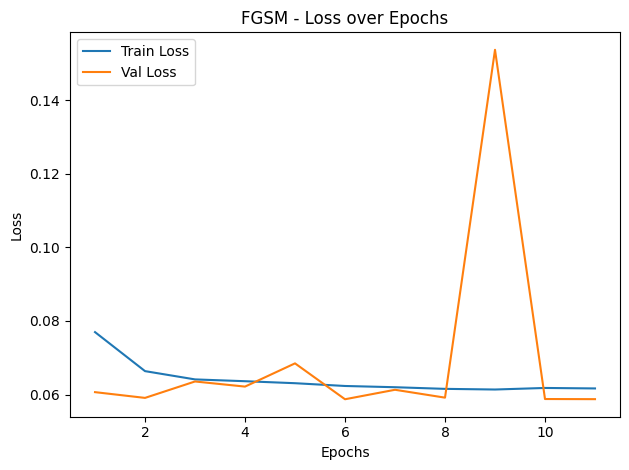

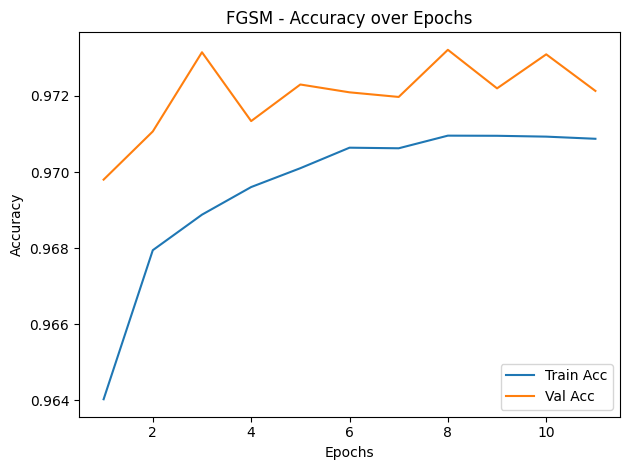

Post-Defence: {'Accuracy': 0.972, 'Precision': 0.972, 'Recall': 0.858, 'F1-score': 0.911}


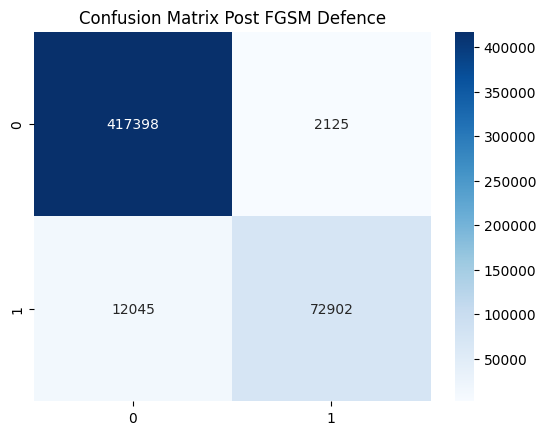

Post PGD: {'Accuracy': 0.832, 'Precision': 0.52, 'Recall': 0.006, 'F1-score': 0.012}


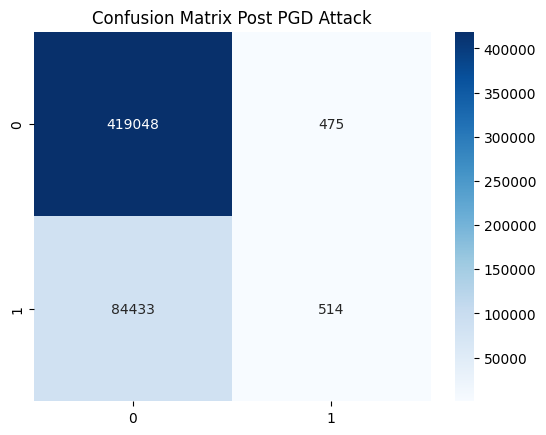


Adversarial training for the attack: PGD.
Epoch 1/100 - Train Loss: 0.0798, Val Loss: 0.0616 - Train Acc: 0.9631, Val Acc: 0.9705
Epoch 2/100 - Train Loss: 0.0689, Val Loss: 0.0628 - Train Acc: 0.9673, Val Acc: 0.9706
Epoch 3/100 - Train Loss: 0.0670, Val Loss: 0.0611 - Train Acc: 0.9682, Val Acc: 0.9705
Epoch 4/100 - Train Loss: 0.0658, Val Loss: 0.0593 - Train Acc: 0.9687, Val Acc: 0.9712
Epoch 5/100 - Train Loss: 0.0651, Val Loss: 0.0603 - Train Acc: 0.9690, Val Acc: 0.9714
Epoch 6/100 - Train Loss: 0.0646, Val Loss: 0.0590 - Train Acc: 0.9692, Val Acc: 0.9716
Epoch 7/100 - Train Loss: 0.0644, Val Loss: 0.0582 - Train Acc: 0.9694, Val Acc: 0.9719
Epoch 8/100 - Train Loss: 0.0642, Val Loss: 0.0586 - Train Acc: 0.9695, Val Acc: 0.9719
Epoch 9/100 - Train Loss: 0.0640, Val Loss: 0.0584 - Train Acc: 0.9696, Val Acc: 0.9723
Epoch 10/100 - Train Loss: 0.0637, Val Loss: 0.0589 - Train Acc: 0.9697, Val Acc: 0.9721
Epoch 11/100 - Train Loss: 0.0634, Val Loss: 0.0589 - Train Acc: 0.9697, Val

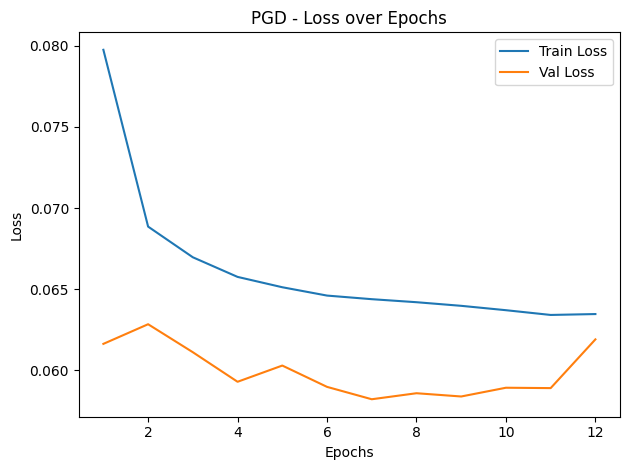

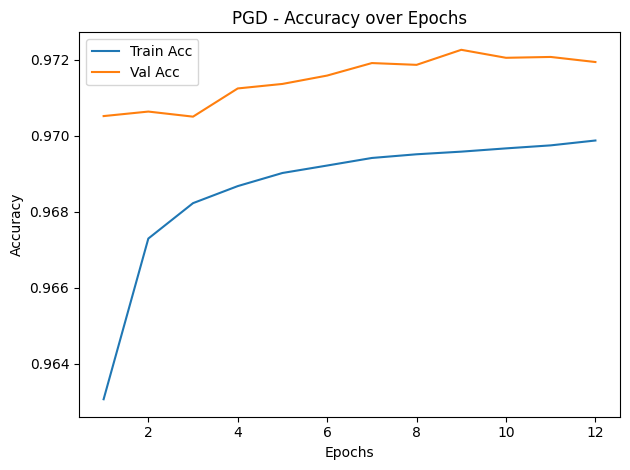

Post-Defence: {'Accuracy': 0.972, 'Precision': 0.958, 'Recall': 0.869, 'F1-score': 0.912}


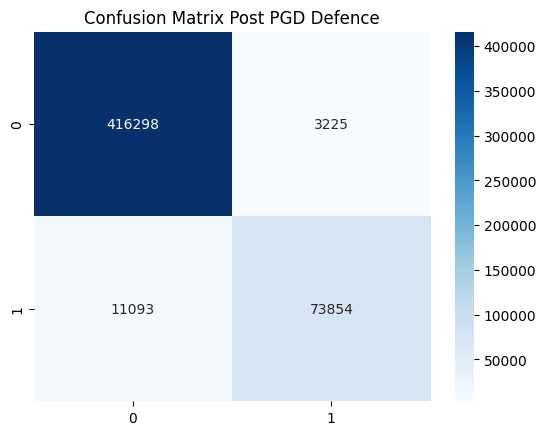

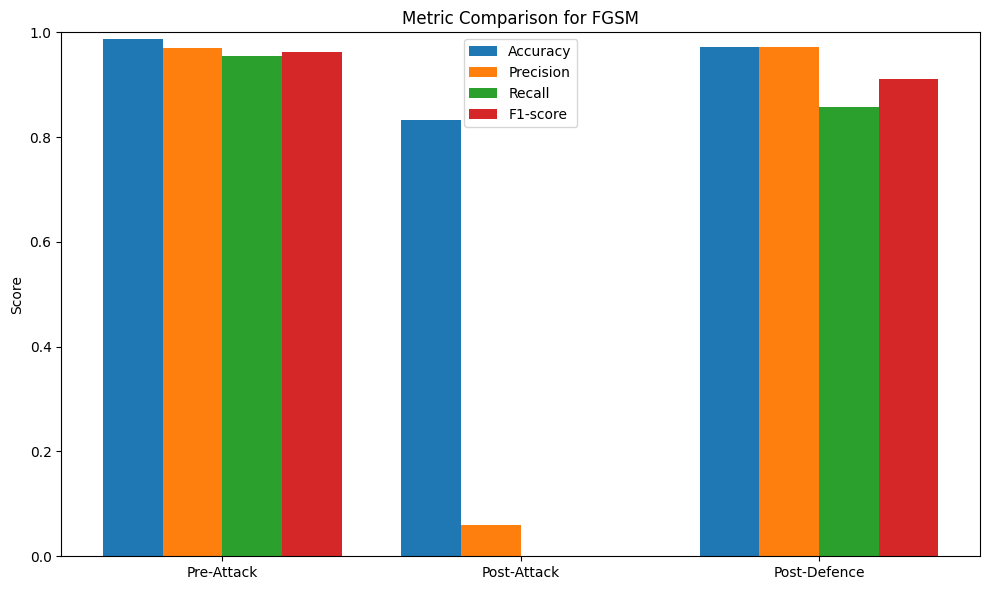

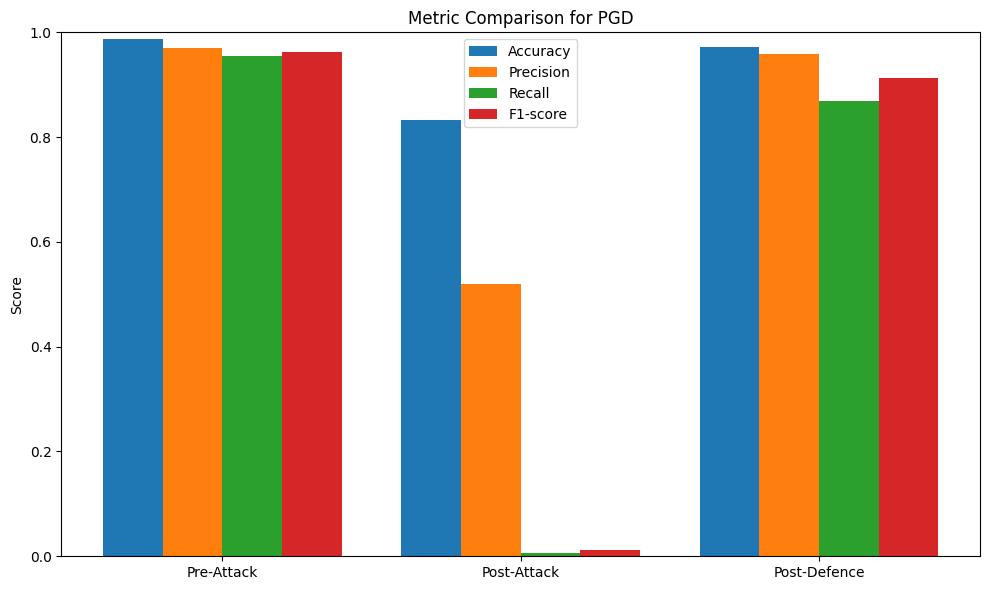

In [40]:
adversarial_training("../data/CIC-IDS-2017.csv", subset_ratio=1.0)